#  Sensitivity application on respirometry

In [1]:
%matplotlib inline

In [52]:
import os
import sys
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.ticker import LinearLocator, MaxNLocator
sns.set_style('whitegrid')

In [53]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14 

In [54]:
import pystran as pyst

In [7]:
# Load the Respiromodel
from respiromodel import Respiro

## Reference respirometric model implementation

In [377]:
from biointense.model import Model
from biointense.measurements import ode_measurements
from biointense.optimisation import ParameterOptimisation
from biointense.sensitivity import NumericalLocalSensitivity

In [399]:
system = {'dS': '-(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X',
          'dX': '(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X - b*X',
          'dDO': '369.73*(8.4-DO)-((1-Y)/Y)*(1.0 - exp(-t/tau))*mu_max*S/(S+K_S)*X',
          'OURex': '((1.- exp(-t/tau))*mu_max*(1-Y)/Y*S/(S+K_S)*X)/(24.*60.)'}

parameters = {'mu_max': 4., 'K_S': 0.4, 'b': 0.62, 'Y': 0.78,
              'tau':2.25e-04}

timestepping = np.linspace(0, 0.05, 1000)
respiro_model = Model('Respirometry', system, parameters)
respiro_model.set_independent({'t': timestepping})
respiro_model.set_initial({'S': 58.48, 'X': 675, 'DO':8.4})

respiro_model.initialize_model()
output = respiro_model.run()
#axs = output.plot(subplots=True, figsize=(12, 8))
#output.index = timestepping

In [400]:
output.tail()

,DO,S,X,OURex
995,8.399989,1.533564e-09,711.481785,2.137131e-09
996,8.399989,1.589380e-09,711.459708,2.214846e-09
997,8.399990,1.628280e-09,711.437631,2.268984e-09
998,8.399990,1.648511e-09,711.415555,2.297105e-09
999,8.399990,1.648267e-09,711.393479,2.296693e-09


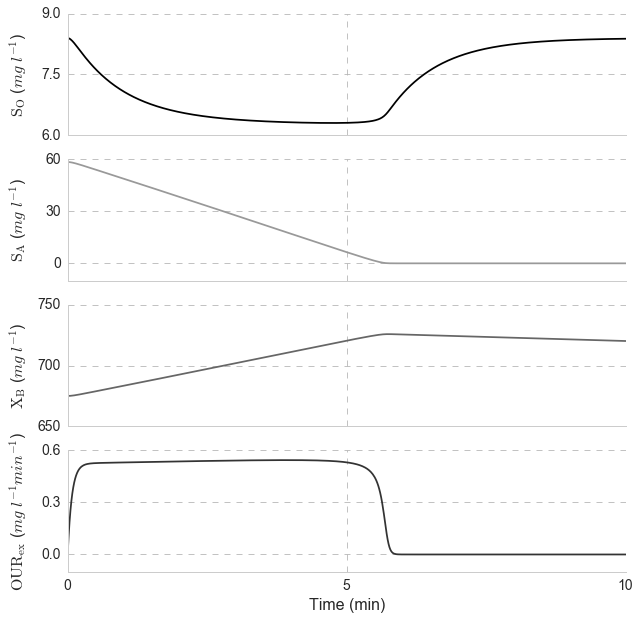

In [411]:
fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(output.index/60., output["DO"], color ='0.') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_{\mathrm{O}}$ ($mg\ l^{-1}$)')
axs[0].set_yticks([6., 7.5, 9.])

axs[1].plot(output.index/60., output["S"],'-', color ='0.6')
axs[1].set_ylabel(r'$\mathrm{S}_{\mathrm{A}}$ ($mg\ l^{-1}$)')
axs[1].set_yticks([0., 30., 60.])

axs[2].plot(output.index/60., output["X"],'-', color ='0.4')
axs[2].set_ylabel(r'$\mathrm{X}_{\mathrm{B}}$ ($mg\ l^{-1}$)')
axs[2].set_yticks([650, 700, 750])

axs[3].plot(output.index/60., output["OURex"],'-', color ='0.2')
axs[3].set_ylabel(r'$\mathrm{OUR}_{\mathrm{ex}}$ ($mg\ l^{-1} min^{-1}$)')
axs[3].set_yticks([0,0.3, 0.6])
axs[3].set_xlim([0, 10])
axs[3].set_xticks([0, 5, 10])
axs[3].set_xlabel('Time (min)')


labelx = -0.07
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_output.png', dpi=300)
plt.savefig('respiro_output.pdf', dpi=300)

## High ratio implementation thesis Stijn DC

In [359]:
###constanten
#####################
m = 0.998224877
C = 64.0
n = 0.942226016
x = 2.
bc = -0.00023307
bh = 0.24
Y = 0.70
p = 0.982527909
ixb = 0.086

Y = 0.70
bh = 0.24
kla = 0.007
A = (m/(C*Y))
B = n*(1-Y)*x/(C*Y)
C = p*ixb/14
D = 0 #geen endogene respiratie want zit samen in bc!
DOi  = 8.91

In [360]:
parameters = {'ks':  1.60, 'tau':77.6 ,'mumax':3.78}
system = {'dSS':'-(1.-exp(-(t/tau)))*(mumax/(3600*24))*XX/('+str(Y)+')*SS/((SS+ks))',
          'dDO':'('+str(kla)+'*('+str(DOi)+' - DO)-(1.-exp(-(t/tau)))*(mumax/(3600*24))*(XX/('+str(Y)+'))*(1-'+str(Y)+')*SS/((SS+ks)))',
          'dXX' :'(1.-exp(-(t/tau)))*(mumax*XX/(3600*24))*SS/(SS+ks)-('+str(bh)+'/(24*3600))*XX'}

In [361]:
timestepping = np.linspace(0, 2400, 2400)
respiro_high = Model('Respirometry', system, parameters)
respiro_high.set_independent({'t': timestepping})
respiro_high.set_initial({'SS':69, 'DO':DOi, 'XX':835})
respiro_high.initialize_model()

In [362]:
69/835.

0.08263473053892216

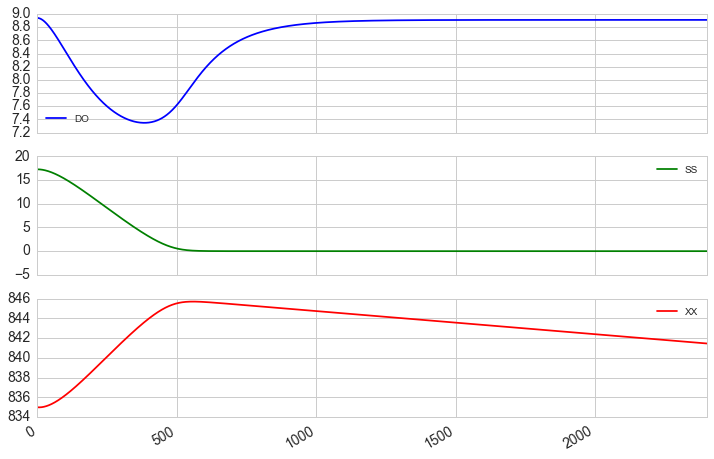

In [363]:
output_high = respiro_high.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output_high.index = timestepping

In [364]:
respiro_high_sens = NumericalLocalSensitivity(respiro_high)
high_cprs = respiro_high_sens.get_sensitivity(method='CPRS')

In [365]:
perc_max = 0.9
high_mumax = high_cprs["DO"]["mumax"][high_cprs["DO"]["mumax"].abs() > high_cprs["DO"]["mumax"].abs().quantile(perc_max)]
high_ks = high_cprs["DO"]["ks"][high_cprs["DO"]["ks"].abs() > high_cprs["DO"]["ks"].abs().quantile(perc_max)]
#ks_split = np.where(high_ks.reset_index().diff()['index'].values > 1)[0][0]
high_tau=high_cprs["DO"]["tau"][high_cprs["DO"]["tau"].abs() > high_cprs["DO"]["tau"].abs().quantile(perc_max)]
tau_split = np.where(high_tau.reset_index().diff()['index'].values > 1)[0][0]

In [366]:
np.where(high_ks.reset_index().diff()['index'].values > 1)[0]

array([], dtype=int64)

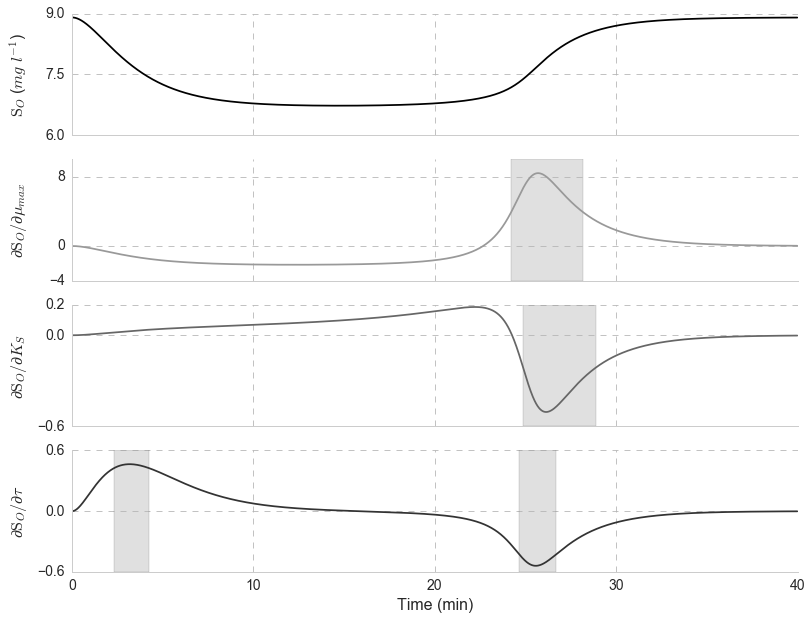

In [367]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(high_cprs.index/60., output_high["DO"], color ='0.', 
            label ='$\mathrm{S}_{O}$') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_O$ ($mg\ l^{-1}$)')
axs[0].set_yticks([6., 7.5, 9.])

axs[1].plot(high_cprs.index/60., high_cprs["DO"]["mumax"],'-', color ='0.6')
axs[1].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial \mu_{max}$')
axs[1].axvspan(high_mumax.index[0]/60., high_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[1].set_yticks([-4., 0, 8.])

axs[2].plot(high_cprs.index/60., high_cprs["DO"]["ks"],'-', color ='0.4')
axs[2].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial K_{S}}$')
#axs[2].axvspan(high_ks.index[0]/60., high_ks.index[ks_split-1]/60., facecolor='0.7', alpha=0.4)
#axs[2].axvspan((high_ks.index[ks_split])/60., high_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].axvspan(high_ks.index[0]/60., high_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].set_yticks([-.6, 0, 0.2])

axs[3].plot(high_cprs.index/60., high_cprs["DO"]["tau"],'-', color ='0.2')
axs[3].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial {\tau}}$')
axs[3].axvspan(high_tau.index[0]/60., high_tau.index[tau_split-1]/60., facecolor='0.7', alpha=0.4)
axs[3].axvspan((high_tau.index[tau_split])/60., high_tau.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[3].axvspan(high_tau.index[0]/60., high_tau.index[-1]/60., facecolor='0.5', alpha=0.4)
axs[3].set_yticks([-.6, 0, 0.6])
axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xlabel('Time (min)')


labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_highratio.png', dpi=600)
plt.savefig('respiro_highratio.pdf', dpi=600)

## Low ratio implementation thesis Stijn DC

In [368]:
####constanten
#m = 0.998224877
C = 64.0
n = 0.942226016
x = 2.
bc = -0.00023307
bh = 0.24
Y = 0.73
p = 0.982527909
ixb = 0.086

Y = 0.73
bh = 0.24
kla = 0.007
A = (m/(C*Y))
B = n*(1-Y)*x/(C*Y)
C = p*ixb/14
D = 0 #geen endogene respiratie want zit samen in bc!
DOi  = 8.94

In [369]:
Modelname = 'Respiromodel_low'

In [370]:
initcond = {'S':12.25, 'DO':DOi, 'X':835}
parameters = {'ks':  3.17, 'tau':155 ,'mumax':7.44}
system = {'dSS':'-(1.-exp(-(t/tau)))*(mumax/(3600*24))*XX/('+str(Y)+')*SS/((SS+ks))',
          'dDO':'('+str(kla)+'*('+str(DOi)+' - DO)-(1.-exp(-(t/tau)))*(mumax/(3600*24))*(XX/('+str(Y)+'))*(1-'+str(Y)+')*SS/((SS+ks)))',
          'dXX' :'(1.-exp(-(t/tau)))*(mumax*XX/(3600*24))*SS/(SS+ks)-('+str(bh)+'/(24*3600))*XX'}

In [398]:
12.25/835

16

In [372]:
timestepping = np.linspace(0, 2400, 2400)
respiro_low = Model('Respirometry', system, parameters)
respiro_low.set_independent({'t': timestepping})
respiro_low.set_initial({'SS':17.25, 'DO':DOi, 'XX':835})
respiro_low.initialize_model()

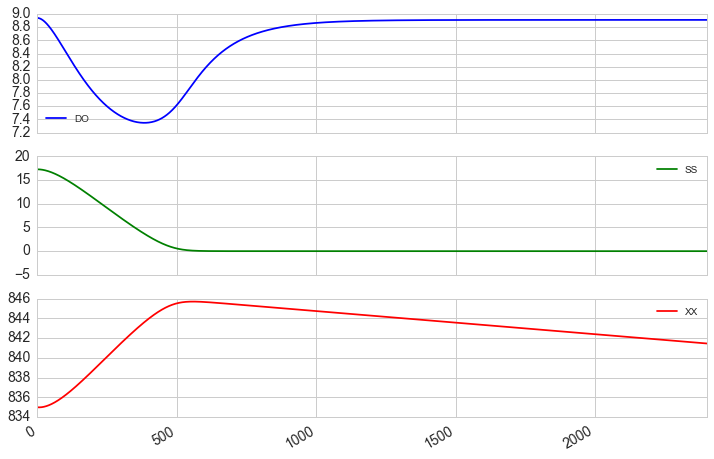

In [373]:
output_low = respiro_low.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output.index = timestepping

In [374]:
respiro_low_sens = NumericalLocalSensitivity(respiro_low)
low_cprs = respiro_low_sens.get_sensitivity(method='CPRS')

In [375]:
#perc_max = 0.9
low_mumax = low_cprs["DO"]["mumax"][low_cprs["DO"]["mumax"].abs() > low_cprs["DO"]["mumax"].abs().quantile(perc_max)]
mumax_split = np.where(low_mumax.reset_index().diff()['index'].values > 1)[0][0]
low_ks = low_cprs["DO"]["ks"][low_cprs["DO"]["ks"].abs() > low_cprs["DO"]["ks"].abs().quantile(perc_max)]
ks_split = np.where(low_ks.reset_index().diff()['index'].values > 1)[0][0]
low_tau=low_cprs["DO"]["tau"][low_cprs["DO"]["tau"].abs() > low_cprs["DO"]["tau"].abs().quantile(perc_max)]
tau_split = np.where(low_tau.reset_index().diff()['index'].values > 1)[0][0]

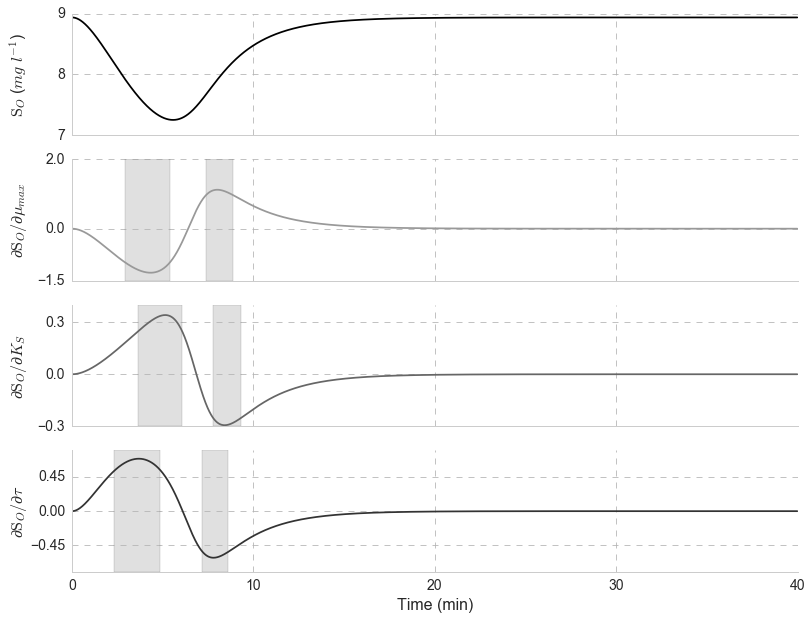

In [376]:
fig, axs = plt.subplots(4, 1, figsize=(13, 10), sharex=True)

axs[0].plot(low_cprs.index/60., output_low["DO"], color ='0.', 
            label ='$\mathrm{S_{O}}$') #, High $S_{}^0/X_{0}$
axs[0].set_ylabel('$\mathrm{S}_O$ ($mg\ l^{-1}$)')
axs[0].set_yticks([7., 8., 9.])

axs[1].plot(low_cprs.index/60., low_cprs["DO"]["mumax"],'-', color ='0.6')
axs[1].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial \mu_{max}$')
axs[1].axvspan(low_mumax.index[0]/60., low_mumax.index[mumax_split-1]/60., facecolor='0.7', alpha=0.4)
axs[1].axvspan((low_mumax.index[mumax_split])/60., low_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[1].axvspan(low_mumax.index[0]/60.,low_mumax.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[1].set_yticks([-1.5, 0, 2.])

axs[2].plot(low_cprs.index/60., low_cprs["DO"]["ks"],'-', color ='0.4')
axs[2].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial K_{S}}$')
axs[2].axvspan(low_ks.index[0]/60., low_ks.index[ks_split-1]/60., facecolor='0.7', alpha=0.4)
axs[2].axvspan((low_ks.index[ks_split])/60., low_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[2].axvspan(low_ks.index[0]/60., low_ks.index[-1]/60., facecolor='0.7', alpha=0.4)
axs[2].set_yticks([-0.3, 0, 0.3])

axs[3].plot(low_cprs.index/60., low_cprs["DO"]["tau"],'-', color ='0.2')
axs[3].set_ylabel(r'$\partial \mathrm{S}_{O}/\partial {\tau}}$')
axs[3].axvspan(low_tau.index[0]/60., low_tau.index[tau_split-1]/60., facecolor='0.7', alpha=0.4)
axs[3].axvspan((low_tau.index[tau_split])/60., low_tau.index[-1]/60., facecolor='0.7', alpha=0.4)
#axs[3].axvspan(high_tau.index[0]/60., high_tau.index[-1]/60., facecolor='0.5', alpha=0.4)
axs[3].set_yticks([-.45, 0, 0.45])
axs[3].set_xticks([0, 10, 20, 30, 40])
axs[3].set_xlabel('Time (min)')

labelx = -0.06
for ax in axs:
    #ax.yaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_label_coords(labelx, 0.5)
    #remove spines
    #ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set grid
    ax.grid(which='major', axis='both', color='0.7',
                 linestyle='--', linewidth=0.8)    

plt.savefig('respiro_lowratio.png', dpi=600)
plt.savefig('respiro_lowratio.pdf', dpi=600)

## Optimisation

### Single peaks

### Combined peaks -> 3pars

### Combined peaks -> step approach